# Importando bibliotecas e dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

import os
from PIL import Image

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_recall_curve,classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import average_precision_score, recall_score, f1_score, roc_curve, auc


import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## Code Functions

In [3]:
def load_and_preprocess_images(image_dir, grayscale = True):
  images = []
  labels = []


  for folder_name in os.listdir(image_dir): # acess folders on Google Drive Directory
    folder_path = os.path.join(image_dir, folder_name)
    if os.path.isdir(folder_path):

      for filename in os.listdir(folder_path): #read images inside each folder
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
          img_path = os.path.join(folder_path, filename)
          try:
              img = Image.open(img_path)
              img = img.resize((224, 224)) # Resize to a consistent size

              if grayscale == True:
              #transform to greyscale
                  img = img.convert('L')
                  img = np.array(img)
                  img = img.reshape(224, 224, 1)

              img = tf.keras.preprocessing.image.img_to_array(img)
              img = img / 255.0 # Normalize pixel values

              if folder_name == "Intact soybeans":
                label = "healthy"
              else:
                label = "unhealthy"

              images.append(img)
              labels.append(label)
          except Exception as e:
              print(f"Error processing image {img_path}: {e}")
              continue
  return tf.convert_to_tensor(images, dtype=tf.float32), tf.convert_to_tensor(labels, dtype=tf.string)


def split_data(image_tensor, label_tensor, test_size=0.2):
    X = np.array(image_tensor)
    y = np.array(label_tensor)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, shuffle=True)
    return X_train, X_test, y_train, y_test

def transform_labels(y):
    transformed_y = np.where(y == b'healthy', 1, 0)
    return transformed_y

def plot_learning_process(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_values, color='black', linewidth=1, label='Training Loss')
    plt.plot(epochs, val_loss_values, color='red', linewidth=1, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().set_facecolor('#f8f9fa')
    plt.tight_layout()
    plt.show()

def plot_precision_recall_metrics(history):
    history_dict = history.history
    train_precision = history_dict.get("precision", history_dict.get("precision_1", []))
    val_precision = history_dict.get("val_precision", history_dict.get("val_precision_1", []))

    train_recall = history_dict.get("recall", history_dict.get("recall_1", []))
    val_recall = history_dict.get("val_recall", history_dict.get("val_recall_1", []))

    epochs = range(1, len(train_precision) + 1)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_precision, color='black', linewidth=1, label='Training Precision')
    plt.plot(epochs, val_precision, color='red', linewidth=1, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().set_facecolor('#f8f9fa')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_recall, color='black', linewidth=1, label='Training Recall')
    plt.plot(epochs, val_recall, color='red', linewidth=1, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().set_facecolor('#f8f9fa')

    plt.tight_layout()
    plt.show()

def plot_auc_metrics(history):
    history_dict = history.history

    train_auc = history_dict.get("AUC", history_dict.get("auc", []))
    val_auc = history_dict.get("val_AUC", history_dict.get("val_auc", []))

    epochs = range(1, len(train_auc) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, train_auc, color='black', linewidth=1, label='Training AUC')
    plt.plot(epochs, val_auc, color='red', linewidth=1, label='Validation AUC')

    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().set_facecolor('#f8f9fa')

    plt.tight_layout()
    plt.show()

def plot_recall_metrics(history):
    history_dict = history.history

    train_recall = history_dict.get("recall", history_dict.get("recall", []))
    val_recall = history_dict.get("val_recall", history_dict.get("val_recall", []))

    epochs = range(1, len(train_recall) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, train_recall, color='black', linewidth=1, label='Training Recall')
    plt.plot(epochs, val_recall, color='red', linewidth=1, label='Validation Recall')

    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().set_facecolor('#f8f9fa')

    plt.tight_layout()
    plt.show()

def extract_metrics(history):
    metrics = {}
    for metric in ['loss', 'val_loss', 'recall', 'val_recall', 'precision', 'val_precision']:
        if metric in history.history:
            metrics[metric] = history.history[metric]
        else:
            print(f"Warning: {metric} not found in history")
            metrics[metric] = None
    return metrics

In [4]:
# importing data
image_dir = "/content/drive/MyDrive/Antonio Pilan/projeto_final_introML/Images"
image_tensor_rgb, label_tensor = load_and_preprocess_images(image_dir, grayscale = False)
label_tensor = transform_labels(label_tensor) #transform label tensor in boolean

X_train, X_test, y_train, y_test = split_data(image_tensor_rgb, label_tensor, test_size=0.6)

#separating each pixel tensor in a separate variable
red_channel = X_train[:, :, :, 0]
green_channel = X_train[:, :, :, 1]
blue_channel = X_train[:, :, :, 2]

#transform rgb tensors into grayscale
image_tensor = tf.image.rgb_to_grayscale(X_train)
grayscale_channel = image_tensor

print("Shape of red channel tensor:", red_channel.shape)
print("Shape of green channel tensor:", green_channel.shape)
print("Shape of blue channel tensor:", blue_channel.shape)
print("Shape of grayscale channel tensor:", grayscale_channel.shape)
print("Shape of Grayscale image tensor:", image_tensor.shape)

print("Shape of label tensor (training):", y_train.shape)
print("Shape of label tensor (test):", y_test.shape)


print("Shape of label tensor:", label_tensor.shape)


Shape of red channel tensor: (2205, 224, 224)
Shape of green channel tensor: (2205, 224, 224)
Shape of blue channel tensor: (2205, 224, 224)
Shape of grayscale channel tensor: (2205, 224, 224, 1)
Shape of Grayscale image tensor: (2205, 224, 224, 1)
Shape of label tensor (training): (2205,)
Shape of label tensor (test): (3308,)
Shape of label tensor: (5513,)


In [5]:
counts = np.bincount(y_train)
total = len(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = total/counts[0]
weight_for_1 = total/counts[1]

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))
################################################################################
counts = np.bincount(y_test)
total = len(y_test)
print(
    "Number of positive samples in test data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

Number of positive samples in training data: 480 (21.77% of total)
Weight for class 0: 1.28
Weight for class 1: 4.59
Number of positive samples in test data: 721 (32.70% of total)


First healthy seed index: 8
First unhealthy seed index: 0


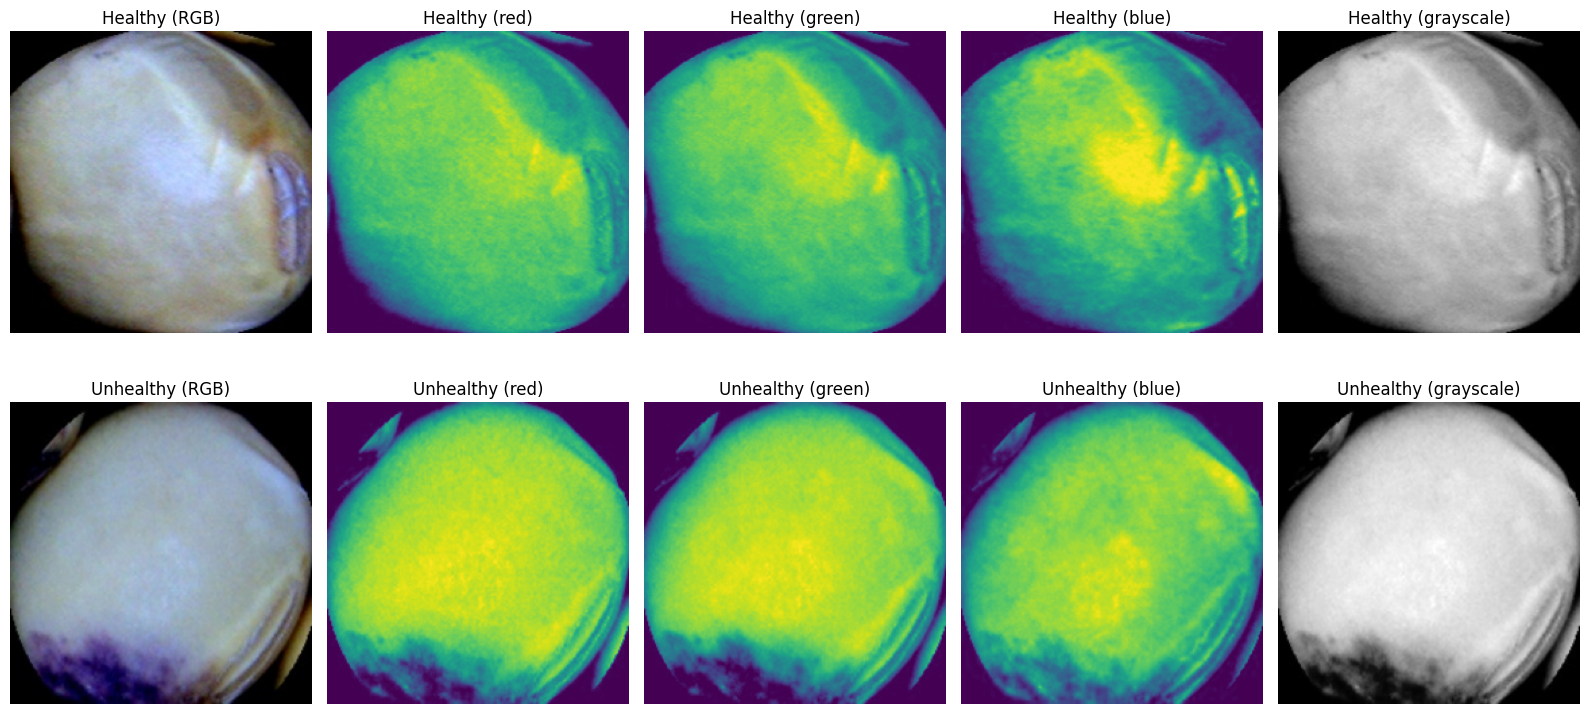

In [6]:
# Find first healthy and unhealthy seed indices
healthy_idx = None
unhealthy_idx = None

for i in range(len(y_train)):
    if y_train[i] == 1 and healthy_idx is None:
        healthy_idx = i
    elif y_train[i] == 0 and unhealthy_idx is None:
        unhealthy_idx = i

    # Break if we found both
    if healthy_idx is not None and unhealthy_idx is not None:
        break

print(f"First healthy seed index: {healthy_idx}")
print(f"First unhealthy seed index: {unhealthy_idx}")

channels = {
    'red': red_channel,
    'green': green_channel,
    'blue': blue_channel,
    'grayscale': grayscale_channel
}

# Plot the channels if indices were found
if healthy_idx is not None and unhealthy_idx is not None:
    plt.figure(figsize=(16, 8))

    # Plot the full RGB images
    plt.subplot(2, 5, 1)
    plt.imshow(X_train[healthy_idx])
    plt.title("Healthy (RGB)")
    plt.axis('off')

    plt.subplot(2, 5, 6)
    plt.imshow(X_train[unhealthy_idx])
    plt.title("Unhealthy (RGB)")
    plt.axis('off')

    # Plot each channel
    for i, (channel_name, channel_data) in enumerate(channels.items(), 1):
        if channel_name == 'grayscale':
            healthy_img = tf.squeeze(channel_data[healthy_idx]).numpy()
            unhealthy_img = tf.squeeze(channel_data[unhealthy_idx]).numpy()
            cmap_val = 'gray'
        else:
            healthy_img = channel_data[healthy_idx]
            unhealthy_img = channel_data[unhealthy_idx]
            cmap_val = 'viridis'

        plt.subplot(2, 5, i+1)
        plt.imshow(healthy_img, cmap=cmap_val)
        plt.title(f"Healthy ({channel_name})")
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(unhealthy_img, cmap=cmap_val)
        plt.title(f"Unhealthy ({channel_name})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not find both healthy and unhealthy examples.")

# *Dealing with class imbalance*

# Model Simulations

## **First exploration: Convolutional Neural Networks with Greyscale images**

In [7]:
X_train_grayscale, X_val_grayscale, y_train_grayscale, y_val_grayscale = split_data(grayscale_channel, y_train, test_size=0.2)
y_train_grayscale = y_train_grayscale.reshape(-1, 1)
y_val_grayscale = y_val_grayscale.reshape(-1, 1)

model_convolutional = tf.keras.models.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

metrics = [
    keras.metrics.F1Score(name="f1score"),
    keras.metrics.Accuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="AUC"),
]

model_convolutional.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                            loss='binary_crossentropy', metrics=metrics)

# Train the model
class_weight = {0: weight_for_0, 1: weight_for_1}
history_convolutional = model_convolutional.fit(
                                                X_train_grayscale, y_train_grayscale,
                                                epochs=1000, batch_size=128,
                                                validation_data=(X_val_grayscale, y_val_grayscale),
                                                class_weight=class_weight,
                                                verbose=0
                                                )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


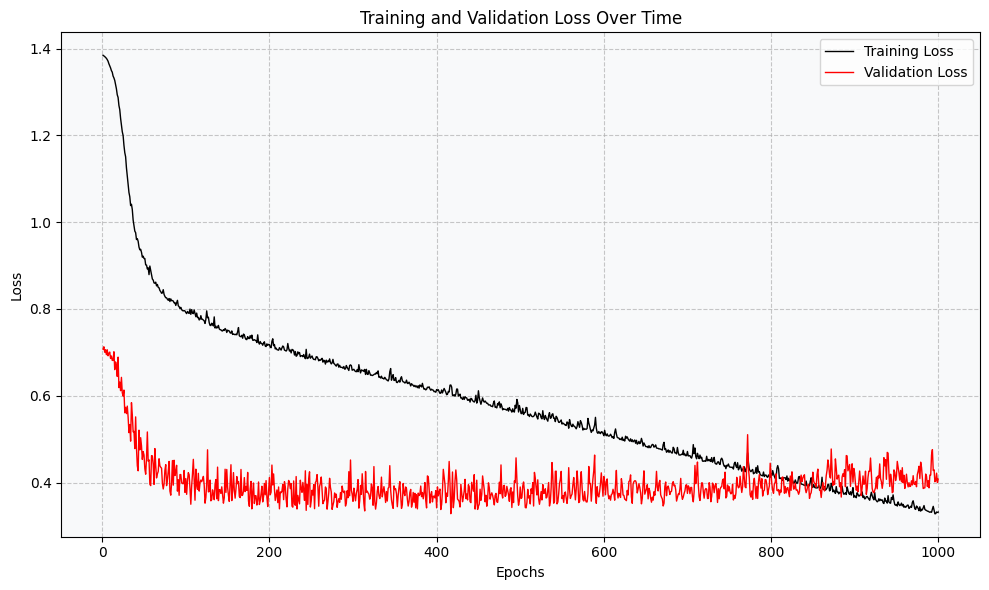

In [8]:
plot_learning_process(history_convolutional)

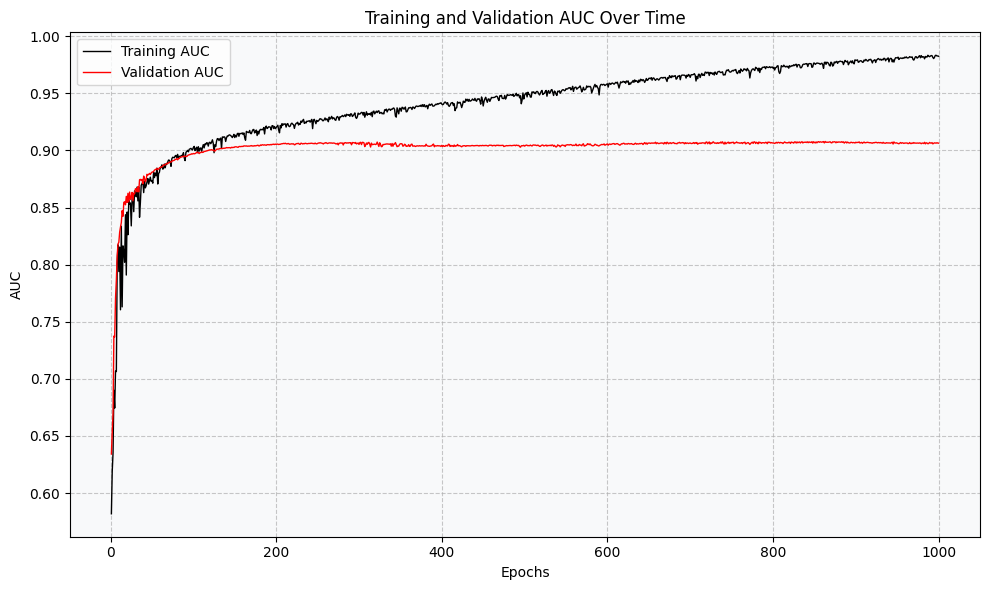

In [9]:
plot_auc_metrics(history_convolutional)

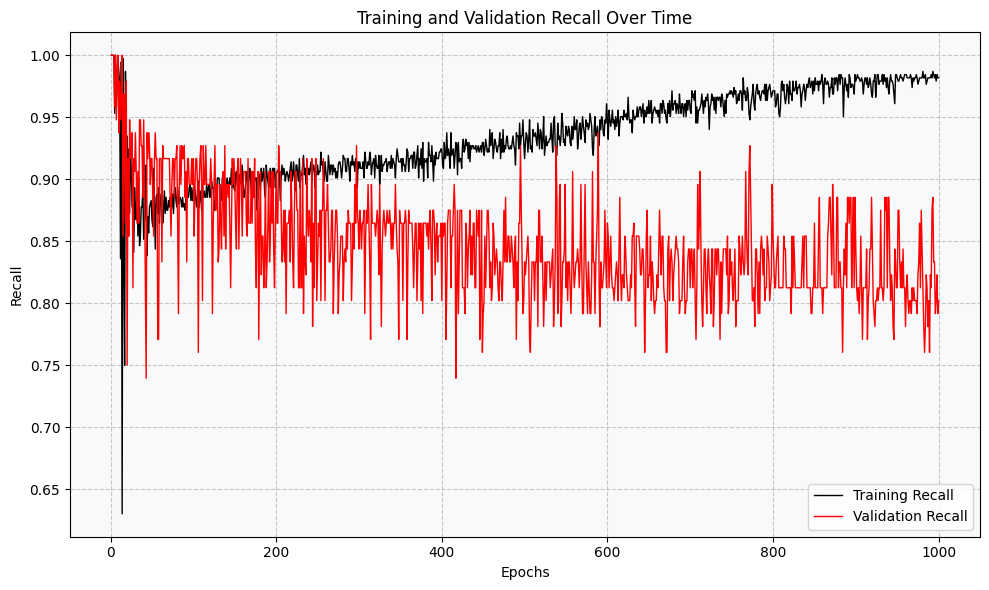

In [10]:
plot_recall_metrics(history_convolutional)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


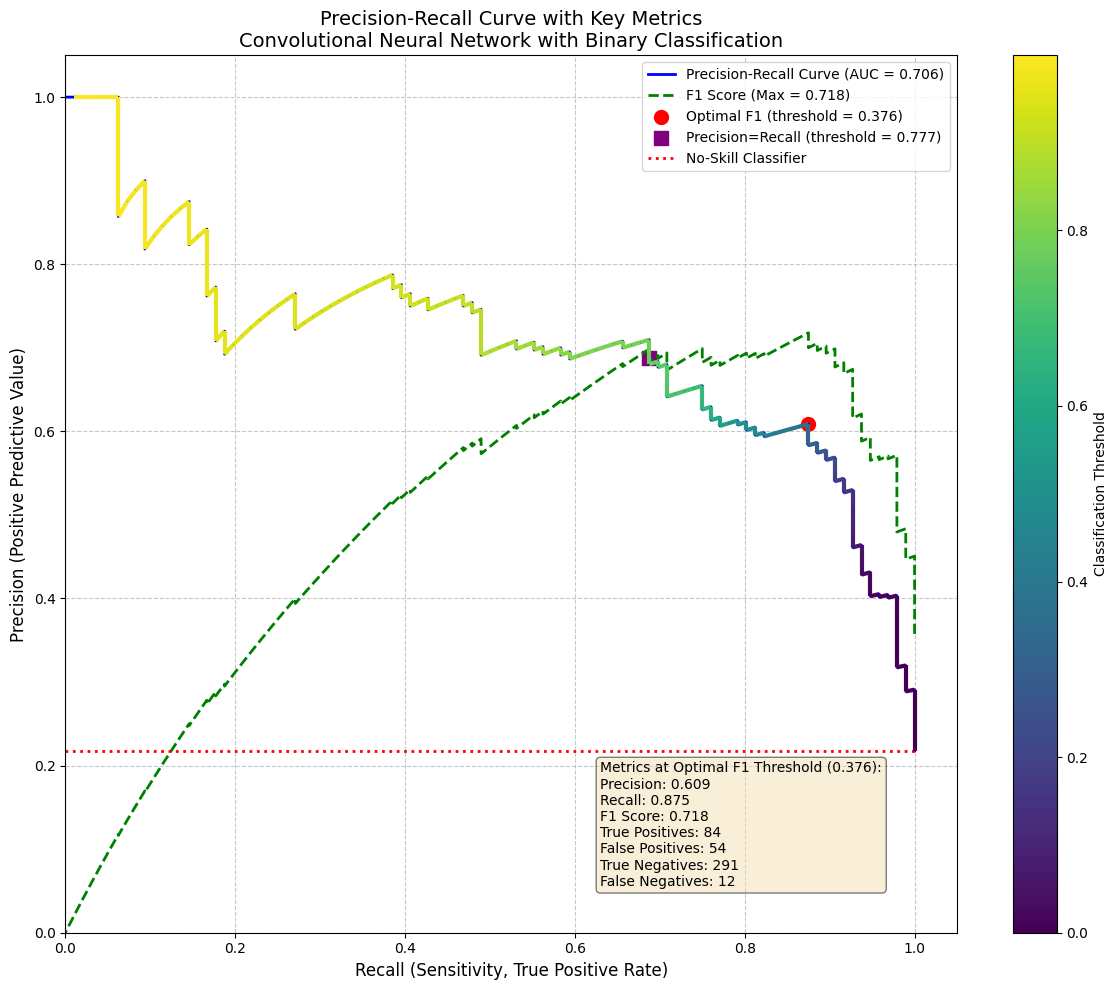

Average Precision (AP): 0.7089
Area Under PR Curve: 0.7064
Optimal F1 Score Threshold: 0.3764 (F1 = 0.7179)
Precision=Recall Threshold: 0.7767 (Value = 0.6875)


In [11]:
y_pred_proba = model_convolutional.predict(X_val_grayscale)
precisions, recalls, thresholds = precision_recall_curve(y_val_grayscale, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_f1_score = thresholds[optimal_idx]

average_precision = average_precision_score(y_val_grayscale, y_pred_proba)

pr_auc = auc(recalls, precisions)

# Find optimal thresholds for different metrics
pr_diff = np.abs(precisions[:-1] - recalls[:-1])
optimal_pr_idx = np.argmin(pr_diff)
optimal_threshold_pr_equal = thresholds[optimal_pr_idx]


plt.figure(figsize=(12, 10))
plt.plot(recalls, precisions, color='b', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
plt.plot(recalls, f1_scores, color='green', lw=2, linestyle='--',
         label=f'F1 Score (Max = {f1_scores[optimal_idx]:.3f})')
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], marker='o', color='red', s=100,
            label=f'Optimal F1 (threshold = {optimal_threshold_f1_score:.3f})')
plt.scatter(recalls[optimal_pr_idx], precisions[optimal_pr_idx], marker='s', color='purple', s=100,
            label=f'Precision=Recall (threshold = {optimal_threshold_pr_equal:.3f})')

# Calculate and display metrics at the optimal F1 threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold_f1_score).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val_grayscale, y_pred_optimal).ravel()
precision_optimal = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_optimal = 2 * (precision_optimal * recall_optimal) / (precision_optimal + recall_optimal) if (precision_optimal + recall_optimal) > 0 else 0

# Textbox
textbox_props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textbox_content = '\n'.join((
    f'Metrics at Optimal F1 Threshold ({optimal_threshold_f1_score:.3f}):',
    f'Precision: {precision_optimal:.3f}',
    f'Recall: {recall_optimal:.3f}',
    f'F1 Score: {f1_optimal:.3f}',
    f'True Positives: {tp}',
    f'False Positives: {fp}',
    f'True Negatives: {tn}',
    f'False Negatives: {fn}'
))
plt.text(0.6, 0.05, textbox_content, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='bottom', bbox=textbox_props)

# No-skill classifier line
plt.plot([0, 1], [np.sum(y_val_grayscale) / len(y_val_grayscale)] * 2,
         color='red', linestyle=':', lw=2, label='No-Skill Classifier')

# Personalization
plt.title('Precision-Recall Curve with Key Metrics\nConvolutional Neural Network with Binary Classification', fontsize=14)
plt.xlabel('Recall (Sensitivity, True Positive Rate)', fontsize=12)
plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)

# Add visualization of threshold changes along the curve
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

points = np.array([recalls[:-1], precisions[:-1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(thresholds.min(), thresholds.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(thresholds)
lc.set_linewidth(3)

line = plt.gca().add_collection(lc)
cbar = plt.colorbar(line, ax=plt.gca())
cbar.set_label('Classification Threshold', fontsize=10)
plt.tight_layout()

plt.show()

# Additional metrics for analysis
print(f"Average Precision (AP): {average_precision:.4f}")
print(f"Area Under PR Curve: {pr_auc:.4f}")
print(f"Optimal F1 Score Threshold: {optimal_threshold_f1_score:.4f} (F1 = {f1_scores[optimal_idx]:.4f})")
print(f"Precision=Recall Threshold: {optimal_threshold_pr_equal:.4f} (Value = {precisions[optimal_pr_idx]:.4f})")

Now, we'll go towards more cientific aproach: K-fold validation and sepparating the test set to avoid *information leaks*

## **Performance metrics: k-fold overfitting analysis and redesigning our model for grayscale**

In [12]:
# model as a function
def create_model(X_train, y_train, X_test=None, y_test=None, class_weight=None, epochs = 200):
    model_convolutional = tf.keras.models.Sequential([
      Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 1)),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(32, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(32, activation='relu'),
      Dense(1, activation='sigmoid') # Output layer for binary classification
      ])

    metrics = [
        keras.metrics.F1Score(name="f1score"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Accuracy(name="accuracy")
    ]

    model_convolutional.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                                loss='binary_crossentropy', metrics=metrics)

    # Train the model
    class_weight = {0: weight_for_0, 1: weight_for_1}
    if X_test is not None and y_test is not None:
      print("Simulation model")
      history_convolutional = model_convolutional.fit(
                                                      X_train, y_train,
                                                      epochs=epochs, batch_size=128,
                                                      validation_data=(X_test, y_test),
                                                      class_weight=class_weight,
                                                      verbose = 0
                                                      )
    else:
      print("Final model")
      history_convolutional = model_convolutional.fit(
                                                      X_train, y_train,
                                                      epochs=epochs, batch_size=128,
                                                      class_weight=class_weight,
                                                      verbose = 0
                                                      )

    return model_convolutional, history_convolutional

The following validation cell was generated via Claude:

Number of positive samples in training data: 384 (17.41% of total)
Class weights - Class 0: 1.278, Class 1: 4.594


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Simulation model
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Fold 1 Results:
F1 Score: 0.6888 at threshold 0.6493
Precision: 0.5724, Recall: 0.8646
PR AUC: 0.7658, ROC AUC: 0.9049
Confusion Matrix: TN=283, FP=62, FN=13, TP=83
Number of positive samples in training data: 384 (17.41% of total)
Class weights - Class 0: 1.278, Class 1: 4.594
Simulation model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Fold 2 Results:
F1 Score: 0.6923 at threshold 0.6837
Precision: 0.7326, Recall: 0.6562
PR AUC: 0.7262, ROC AUC: 0.8974
Confusion Matrix: TN=322, FP=23, FN=33, TP=63
Number of positive samples in training data: 384 (17.41% of total)
Class weights - Class 0: 1.278, Class 1: 4.594
Simulation model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Fold 3 Results:
F1 Score: 0.6866 at threshold 0.7285
Precision: 0.6571, Recall: 0.7188
PR AUC: 0.7169, ROC AUC: 0.8933
Confusion Matrix: TN=309, FP=36, FN=27, TP=69
Number of positive samples in training data: 384 (17.41% of total)
Class weights - Class 0: 1.278, Class 1: 4.594
Simulation model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Fold 4 Results:
F1 Score: 0.7442 at threshold 0.5802
Precision: 0.6723, Recall: 0.8333
PR AUC: 0.7502, ROC AUC: 0.9208
Confusion Matrix: TN=306, FP=39, FN=16, TP=80
Number of positive samples in training data: 384 (17.41% of total)
Class weights - Class 0: 1.278, Class 1: 4.594
Simulation model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Fold 5 Results:
F1 Score: 0.6827 at threshold 0.7062
Precision: 0.6339, Recall: 0.7396
PR AUC: 0.7346, ROC AUC: 0.8955
Confusion Matrix: TN=304, FP=41, FN=25, TP=71


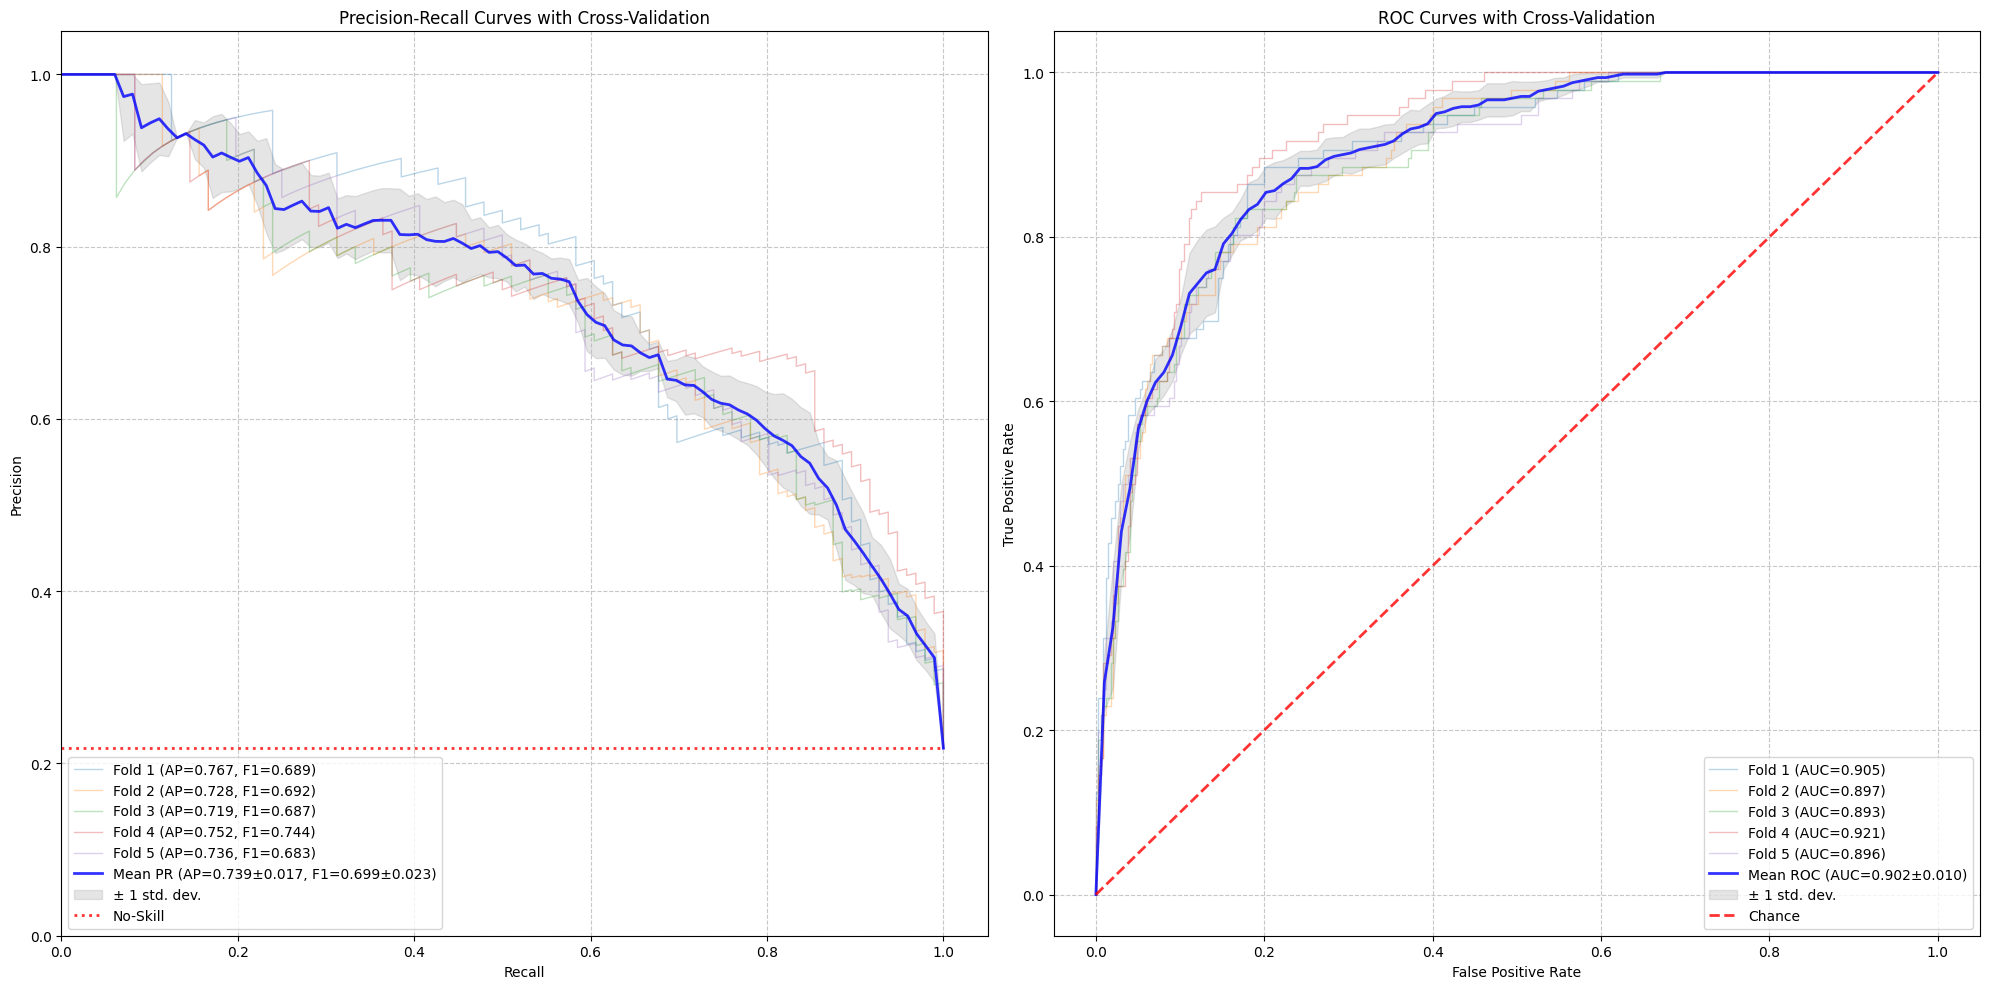

In [13]:
# Initialize variables to store best model and metrics
best_model = None
best_fold_metrics = None
best_f1_score = -1
best_fold_idx = -1
best_threshold = 0.5
best_class_weight = None

# Storage for metrics across all folds
all_fold_metrics = {}
f1_scores_across_folds = []
pr_aucs_across_folds = []
roc_aucs_across_folds = []
thresholds_across_folds = []
minimal_epoch = []

# Storage for curves data for averaging
all_precisions = []
all_recalls = []
mean_recall = np.linspace(0, 1, 100)  # For interpolation of PR curves
all_tprs = []
all_fprs = []
mean_fpr = np.linspace(0, 1, 100)  # For interpolation of ROC curves

# Set up figure for visualization
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)  # For Precision-Recall curve
plt.subplot(1, 2, 2)  # For ROC curve

# Prepare your data
X_data = grayscale_channel  # Your input data (assuming grayscale_channel is defined)
y_data = y_train  # Your target variable (assuming y_train is defined)

# Start k-fold cross-validation
for k in range(5):

    # Split data for this fold
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = split_data(X_data, y_data, test_size=0.2)
    y_train_fold = y_train_fold.reshape(-1, 1)
    y_val_fold = y_val_fold.reshape(-1, 1)

    # Calculate class weights for this fold
    counts = np.bincount(y_train_fold.flatten())
    total = len(y_train_fold)
    print(
        "Number of positive samples in training data: {} ({:.2f}% of total)".format(
            counts[1], 100 * float(counts[1]) / len(y_train)
        )
    )

    weight_for_0 = total/counts[0]
    weight_for_1 = total/counts[1]
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print(f"Class weights - Class 0: {weight_for_0:.3f}, Class 1: {weight_for_1:.3f}")

    # Use your create_model function
    fold_model, fold_history = create_model(
        X_train_fold, y_train_fold,
        X_val_fold, y_val_fold,
        class_weight
    )

    # Get predictions on validation set
    y_pred_proba = fold_model.predict(X_val_fold)

    # Ensure we have the correct shape for y_pred_proba
    if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
        y_pred_proba = y_pred_proba[:, 1]

    # ===== F1 Score and PR Curve Analysis =====
    # Calculate precision-recall curve and metrics
    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_pred_proba)

    # Calculate F1 scores for each threshold
    # Add small epsilon to avoid division by zero
    epsilon = 1e-8
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + epsilon)

    # Find optimal threshold that maximizes F1 score
    optimal_idx = np.argmax(f1_scores[:-1])  # Exclude the last point as it doesn't have a threshold
    optimal_threshold_f1 = thresholds[optimal_idx]
    max_f1_score = f1_scores[optimal_idx]

    # Calculate average precision and PR AUC
    average_precision = average_precision_score(y_val_fold, y_pred_proba)
    pr_auc = auc(recalls, precisions)

    # Find point where precision equals recall
    pr_diff = np.abs(precisions[:-1] - recalls[:-1])
    optimal_pr_idx = np.argmin(pr_diff)
    optimal_threshold_pr_equal = thresholds[optimal_pr_idx]

    # ===== ROC Curve Analysis =====
    # Calculate ROC curve and AUC
    fpr, tpr, roc_thresholds = roc_curve(y_val_fold, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Interpolate the TPR values for ROC curve averaging
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0  # Force the curve to start at (0,0)
    all_tprs.append(interp_tpr)

    # Interpolate precision values for PR curve averaging
    # Note: PR curve is not as easily averaged as ROC due to its non-monotonic nature
    interp_precision = np.interp(mean_recall, recalls[::-1], precisions[::-1])
    all_precisions.append(interp_precision)

    # ===== Calculate metrics at optimal threshold =====
    y_pred_optimal = (y_pred_proba >= optimal_threshold_f1).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_optimal).ravel()

    precision_optimal = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_optimal = 2 * (precision_optimal * recall_optimal) / (precision_optimal + recall_optimal) if (precision_optimal + recall_optimal) > 0 else 0

    # ===== Store metrics for this fold =====
    fold_metrics = {
        "model": fold_model,
        "history": fold_history,
        "val_loss": np.min(fold_history.history['val_loss']),
        "epoch_min_val_loss": np.argmin(fold_history.history['val_loss']),
        "f1_optimal": f1_optimal,
        "precision_optimal": precision_optimal,
        "recall_optimal": recall_optimal,
        "pr_auc": pr_auc,
        "average_precision": average_precision,
        "roc_auc": roc_auc,
        "optimal_threshold_f1": optimal_threshold_f1,
        "optimal_threshold_pr_equal": optimal_threshold_pr_equal,
        "confusion_matrix": {
            "true_negatives": tn,
            "false_positives": fp,
            "false_negatives": fn,
            "true_positives": tp
        },
        "class_weight": class_weight
    }

    all_fold_metrics[k] = fold_metrics
    f1_scores_across_folds.append(f1_optimal)
    pr_aucs_across_folds.append(pr_auc)
    roc_aucs_across_folds.append(roc_auc)
    thresholds_across_folds.append(optimal_threshold_f1)
    minimal_epoch.append(np.argmin(fold_history.history['val_loss']))

    # Check if this is the best fold so far based on F1 score
    if f1_optimal > best_f1_score:
        best_f1_score = f1_optimal
        best_fold_idx = k
        best_model = fold_model
        best_fold_metrics = fold_metrics
        best_threshold = optimal_threshold_f1
        best_class_weight = class_weight

    # Print fold results
    print(f"\nFold {k+1} Results:")
    print(f"F1 Score: {f1_optimal:.4f} at threshold {optimal_threshold_f1:.4f}")
    print(f"Precision: {precision_optimal:.4f}, Recall: {recall_optimal:.4f}")
    print(f"PR AUC: {pr_auc:.4f}, ROC AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # Plot PR curve for this fold
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions, lw=1, alpha=0.3,
             label=f'Fold {k+1} (AP={average_precision:.3f}, F1={f1_optimal:.3f})')

    # Plot ROC curve for this fold
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label=f'Fold {k+1} (AUC={roc_auc:.3f})')

# Calculate mean metrics across folds
mean_f1 = np.mean(f1_scores_across_folds)
std_f1 = np.std(f1_scores_across_folds)
mean_pr_auc = np.mean(pr_aucs_across_folds)
std_pr_auc = np.std(pr_aucs_across_folds)
mean_roc_auc = np.mean(roc_aucs_across_folds)
std_roc_auc = np.std(roc_aucs_across_folds)
mean_threshold = np.mean(thresholds_across_folds)

# Calculate mean PR curve
mean_precision = np.mean(all_precisions, axis=0)
std_precision = np.std(all_precisions, axis=0)

# Calculate mean ROC curve
mean_tpr = np.mean(all_tprs, axis=0)
mean_tpr[-1] = 1.0  # Force the curve to end at (1,1)
std_tpr = np.std(all_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

# Finalize PR Curve plot
plt.subplot(1, 2, 1)
plt.plot(mean_recall, mean_precision, color='b',
         label=f'Mean PR (AP={mean_pr_auc:.3f}±{std_pr_auc:.3f}, F1={mean_f1:.3f}±{std_f1:.3f})',
         lw=2, alpha=0.8)
# Add confidence interval for PR curve (this is approximate due to PR curve's nature)
plt.fill_between(mean_recall,
                 np.maximum(mean_precision - std_precision, 0),
                 np.minimum(mean_precision + std_precision, 1),
                 color='grey', alpha=0.2,
                 label='± 1 std. dev.')
# Plot baseline (no skill classifier)
plt.plot([0, 1], [np.mean(y_data)] * 2, linestyle=':', color='r',
         label='No-Skill', lw=2, alpha=0.8)

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves with Cross-Validation')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.7)

# Finalize ROC Curve plot
plt.subplot(1, 2, 2)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Mean ROC (AUC={mean_roc_auc:.3f}±{std_roc_auc:.3f})',
         lw=2, alpha=0.8)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label='± 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with Cross-Validation')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [14]:
# Print summary of cross-validation results
print("\n" + "="*80)
print("Cross Validation Results:")
print("="*80)
print(f"Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean PR AUC: {mean_pr_auc:.4f} ± {std_pr_auc:.4f}")
print(f"Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
print(f"Mean Optimal Threshold: {mean_threshold:.4f}")
print("\nIndividual Fold Metrics:")
metrics_df = pd.DataFrame({
    'Fold': range(1, 6),
    'F1 Score': f1_scores_across_folds,
    'PR AUC': pr_aucs_across_folds,
    'ROC AUC': roc_aucs_across_folds,
    'Optimal Threshold': thresholds_across_folds,
    'minimal epoch': minimal_epoch,
})
print(metrics_df)


Cross Validation Results:
Mean F1 Score: 0.6989 ± 0.0229
Mean PR AUC: 0.7387 ± 0.0174
Mean ROC AUC: 0.9024 ± 0.0100
Mean Optimal Threshold: 0.6696

Individual Fold Metrics:
   Fold  F1 Score    PR AUC   ROC AUC  Optimal Threshold  minimal epoch
0     1  0.688797  0.765762  0.904921           0.649347            174
1     2  0.692308  0.726171  0.897373           0.683708            188
2     3  0.686567  0.716947  0.893267           0.728520            184
3     4  0.744186  0.750193  0.920773           0.580238            185
4     5  0.682692  0.734560  0.895501           0.706202            197


# **Developing the final model**

In [15]:
y_train_final = y_train.reshape(-1, 1)

# final model implementation
counts = np.bincount(y_train.flatten())
total = len(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = total/counts[0]
weight_for_1 = total/counts[1]
class_weight = {0: weight_for_0, 1: weight_for_1}

epochs = int(metrics_df['minimal epoch'].mean()) #that minimizes loss
optimal_treshold = metrics_df['Optimal Threshold'].mean() #that maximizes f1-score

print(f"Class weights - Class 0: {weight_for_0:.3f}, Class 1: {weight_for_1:.3f}")

final_model = tf.keras.models.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

metrics = [
    keras.metrics.F1Score(name="f1score"),
    keras.metrics.Accuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="AUC"),
]

final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                            loss='binary_crossentropy', metrics=metrics)

# Train the model
history = final_model.fit(
                                  grayscale_channel, y_train_final,
                                  epochs=epochs, batch_size=128,
                                  class_weight=class_weight,
                                  verbose=0
                                  )

Number of positive samples in training data: 480 (21.77% of total)
Class weights - Class 0: 1.278, Class 1: 4.594


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Final Model performance (TEST DATA)
Optimal Threshold Used (from CV mean): 0.6696
Test Accuracy: 0.8371
Test Precision: 0.5974
Test Recall: 0.7739
Test F1 Score: 0.6743


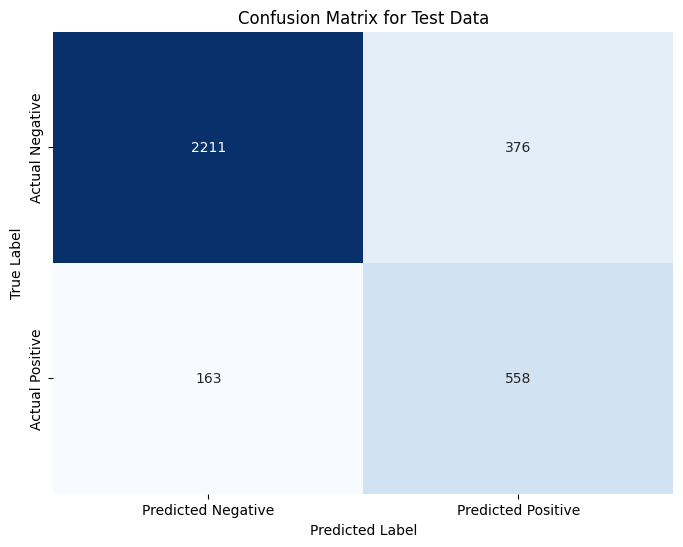

In [16]:
X_test_grayscale = tf.image.rgb_to_grayscale(X_test)
y_pred_proba_test = final_model.predict(X_test_grayscale)

# Convert probabilities to binary predictions
y_pred_test = (y_pred_proba_test >= optimal_treshold).astype(int)

# Calculate and print test metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1_score = f1_score(y_test, y_pred_test)
test_confusion_matrix = confusion_matrix(y_test, y_pred_test)

print("\n" + "="*80)
print("Final Model performance (TEST DATA)")
print("="*80)
print(f"Optimal Threshold Used (from CV mean): {optimal_treshold:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Data')
plt.show()